#### SVI data Analysis

###### American National Standards Institute (ANSI) Codes for States
###### Virginia:VA: 51
###### Maryland:MD: 24
###### West Virginia:WV: 54
###### District of Columbia:DC: 11

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import itertools
from itertools import combinations
from scipy import spatial
import pickle as pickle
import gudhi
from pylab import *
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import seaborn as sns
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from matplotlib import pyplot
import warnings

# Ignore FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# imoporting SVI data for the entire US(county level) 
us_svi = gpd.read_file('./data/SVI data/SVI2020_US_county.gdb')

In [3]:
# include only the Washington DC, Virginia, Maryland, and West Virginia(county level)
filtered_svi_df = us_svi[us_svi['ST_ABBR'].isin(['VA', 'MD', 'WV', 'DC'])]

In [4]:
# reset index
filtered_svi_df.reset_index(drop=True, inplace=True)

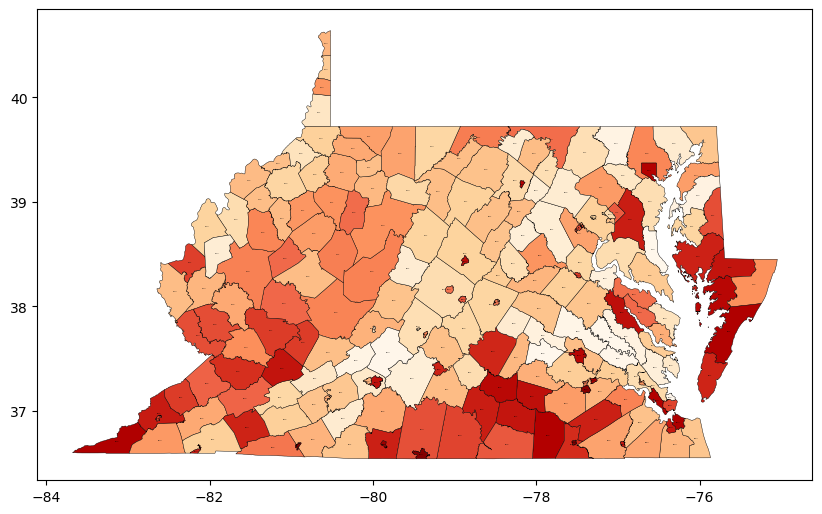

In [5]:
# Plot the data for the Washington DC, Virginia, Maryland, and West Virginia(county level)
ax = filtered_svi_df.plot(figsize=(10, 10), column="RPL_THEMES", legend=False, cmap='OrRd', edgecolor='black',linewidth=0.3)

for idx, row in filtered_svi_df.iterrows():
    centroid = row.geometry.centroid
    county_name = row.FIPS
    ax.annotate(text=county_name, xy=(centroid.x, centroid.y), ha='center', fontsize=0.5)

# Display the plot
plt.show()

In [6]:
# checking the data type of the FIPS column
print(type(filtered_svi_df['FIPS'][0]))

<class 'str'>


In [7]:
filtered_svi_df.head(3)

,ST,STATE,ST_ABBR,STCNTY,COUNTY,FIPS,LOCATION,AREA_SQMI,E_TOTPOP,M_TOTPOP,...,MP_AIAN,EP_NHPI,MP_NHPI,EP_TWOMORE,MP_TWOMORE,EP_OTHERRACE,MP_OTHERRACE,Shape_Length,Shape_Area,geometry
0,11,District of Columbia,DC,11001,District of Columbia,11001,"District of Columbia, District of Columbia",61.126172,701974,0,...,0.1,0.0,0.1,2.9,0.2,0.5,0.1,0.645734,0.018374,"MULTIPOLYGON (((-77.11976 38.93434, -77.11253 ..."
1,24,Maryland,MD,24001,Allegany,24001,"Allegany County, Maryland",422.203330,71002,0,...,0.1,0.0,0.1,2.2,0.4,0.1,0.1,2.647485,0.116232,"MULTIPOLYGON (((-79.06756 39.47944, -79.06003 ..."
2,24,Maryland,MD,24003,Anne Arundel,24003,"Anne Arundel County, Maryland",414.809757,575421,0,...,0.1,0.0,0.1,4.2,0.4,0.3,0.1,2.222859,0.121041,"MULTIPOLYGON (((-76.83849 39.10421, -76.83047 ..."


#### Overdose data (2020)
we need to combine Overdose data to the svi dataframe

In [8]:

# this contains mortality data for the Washington DC, Virginia, Maryland, and West Virginia(county level)
mortality_df = pd.read_csv('./data/Mortality data/Current Final Multiple Cause of Death Data/DCMetroDeaths_2018_2021.csv')

In [9]:
# rename county code column to FIPS
mortality_df.rename(columns={'County Code':'FIPS'}, inplace=True)

In [10]:
# convert FIPS column to string
mortality_df['FIPS'] = mortality_df['FIPS'].astype(str)

In [11]:
# filtering the mortality data for year 2020
mortality_df_2020 = mortality_df[mortality_df['Year']==2020]
mortality_df_2020.reset_index(drop=True, inplace=True)

In [12]:
mortality_df_2020.head(3)

,State,County,FIPS,Year,Year Code,Deaths,Population,Crude Rate
0,WV,"Barbour County, WV",54001,2020,2020,Suppressed,16444,Suppressed
1,WV,"Berkeley County, WV",54003,2020,2020,112,122125,91.7
2,WV,"Boone County, WV",54005,2020,2020,24,21055,114


In [13]:
# Assuming filtered_df has the 'od_deaths' column
od_deaths_counts = mortality_df_2020['Deaths'].value_counts()

# Print the counts of each unique value in the 'od_deaths' column
print(od_deaths_counts)

Suppressed    95
10            10
12             6
0              5
17             5
18             5
11             4
22             4
19             3
16             3
38             3
21             3
13             3
33             3
24             3
30             2
112            2
29             2
37             2
23             2
60             2
49             2
35             2
26             2
99             2
15             2
52             2
34             2
14             2
194            1
106            1
80             1
442            1
59             1
36             1
149            1
227            1
122            1
104            1
46             1
20             1
849            1
280            1
53             1
75             1
146            1
54             1
87             1
69             1
65             1
111            1
28             1
121            1
126            1
103            1
39             1
40             1
67             1
432           

In [14]:
# Merge the dataframes on the 'FIPS' column(this will include all the 2020 data for the Washington DC, Virginia, Maryland, and West Virginia(county level))
merged_df_VA_MD_DC_WV = pd.merge(filtered_svi_df, mortality_df_2020[['FIPS', 'Deaths']],
                     on='FIPS', how='left')

In [15]:

# Rename the 'Provisional Drug Overdose Deaths' column to 'od_deaths'
# merged_df.rename(columns={'Provisional Drug Overdose Deaths': 'od_deaths'}, inplace=True)

# If there are NaN values in 'od_deaths' column, you can fill them with a default value, for example, 0
# merged_df['Deaths'].fillna(0, inplace=True)

# Now, merged_df contains the new column 'od_deaths' based on matching FIPS codes

In [16]:
merged_df_VA_MD_DC_WV.head(3)

,ST,STATE,ST_ABBR,STCNTY,COUNTY,FIPS,LOCATION,AREA_SQMI,E_TOTPOP,M_TOTPOP,...,EP_NHPI,MP_NHPI,EP_TWOMORE,MP_TWOMORE,EP_OTHERRACE,MP_OTHERRACE,Shape_Length,Shape_Area,geometry,Deaths
0,11,District of Columbia,DC,11001,District of Columbia,11001,"District of Columbia, District of Columbia",61.126172,701974,0,...,0.0,0.1,2.9,0.2,0.5,0.1,0.645734,0.018374,"MULTIPOLYGON (((-77.11976 38.93434, -77.11253 ...",432
1,24,Maryland,MD,24001,Allegany,24001,"Allegany County, Maryland",422.203330,71002,0,...,0.0,0.1,2.2,0.4,0.1,0.1,2.647485,0.116232,"MULTIPOLYGON (((-79.06756 39.47944, -79.06003 ...",52
2,24,Maryland,MD,24003,Anne Arundel,24003,"Anne Arundel County, Maryland",414.809757,575421,0,...,0.0,0.1,4.2,0.4,0.3,0.1,2.222859,0.121041,"MULTIPOLYGON (((-76.83849 39.10421, -76.83047 ...",280


##### Now I need to extract specifically Washington DC Metropolitan Area SVI dataset.

In [17]:
# this contais Washington DC Metro area counties(shapefile)
metro_map_df = gpd.read_file('./data/DC_Metro_counties/Washington_Arlington_Alexandria_DC_VA_MD_WV_Counties.shp')

In [18]:
metro_map_df.head(3)

,OBJECTID,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,...,Shape_Area,CBSAFP,METDIVFP,CSAFP,CBSA_Title,M_Status,MDIV_Title,CSA_Title,C_Status,geometry
0,734,54,037,01550025,54037,Jefferson,Jefferson County,06,H1,G4020,...,0.057252,47900,47894,548,"Washington-Arlington-Alexandria, DC-VA-MD-WV",Metropolitan Statistical Area,"Washington-Arlington-Alexandria, DC-VA-MD-WV","Washington-Baltimore-Arlington, DC-MD-VA-WV-PA",Outlying,"POLYGON ((-78.03541 39.27841, -78.03526 39.278..."
1,1266,24,009,01676636,24009,Calvert,Calvert County,06,H1,G4020,...,0.092340,47900,47894,548,"Washington-Arlington-Alexandria, DC-VA-MD-WV",Metropolitan Statistical Area,"Washington-Arlington-Alexandria, DC-VA-MD-WV","Washington-Baltimore-Arlington, DC-MD-VA-WV-PA",Outlying,"POLYGON ((-76.56813 38.40771, -76.57181 38.408..."
2,1297,24,033,01714670,24033,Prince George's,Prince George's County,06,H1,G4020,...,0.134028,47900,47894,548,"Washington-Arlington-Alexandria, DC-VA-MD-WV",Metropolitan Statistical Area,"Washington-Arlington-Alexandria, DC-VA-MD-WV","Washington-Baltimore-Arlington, DC-MD-VA-WV-PA",Central,"POLYGON ((-77.04202 38.74672, -77.04191 38.750..."


In [19]:
# In the metro shapefile GEOID contains the FIPS code
# metro_svi_deaths will contains SVI and fatalities data for the Washington DC Metro area counties
metro_svi_deaths = merged_df_VA_MD_DC_WV[merged_df_VA_MD_DC_WV['FIPS'].isin(metro_map_df['GEOID'].tolist())]
metro_svi_deaths.reset_index(drop=True, inplace=True)

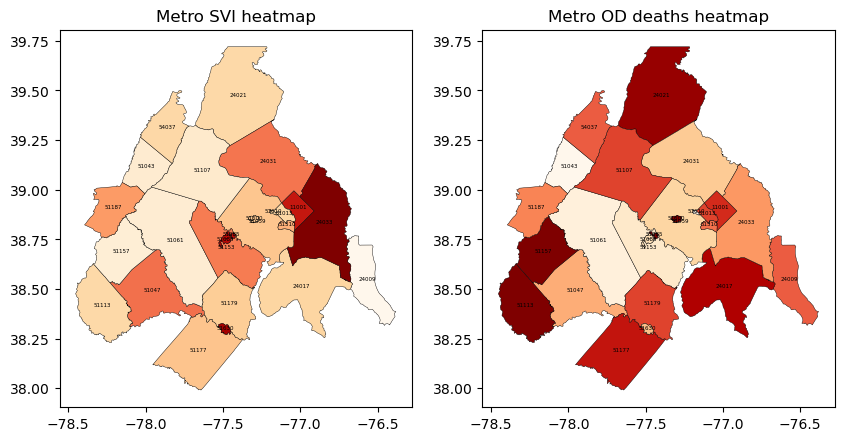

In [20]:
# Plot the data side by side using subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 10))

# Plot for filtered_result (assuming filtered_result is your filtered dataframe)
ax1 = metro_svi_deaths.plot(ax=axes[0], column="RPL_THEMES", legend=False, cmap='OrRd', edgecolor='black', linewidth=0.3)
ax1.set_title('Metro SVI heatmap')

# Plot for filtered_merged_df (assuming filtered_merged_df is your first filtered dataframe)
ax2 = metro_svi_deaths.plot(ax=axes[1], column="Deaths", legend=False, cmap='OrRd', edgecolor='black', linewidth=0.3)
ax2.set_title('Metro OD deaths heatmap')

# Annotate the plots
for ax in [ax1, ax2]:
    for idx, row in metro_svi_deaths.iterrows():
        centroid = row.geometry.centroid
        county_name = row.FIPS
        ax.annotate(text=county_name, xy=(centroid.x, centroid.y), ha='center', fontsize=4)

# Display the plots
plt.show()

In [21]:
metro_svi_deaths

,ST,STATE,ST_ABBR,STCNTY,COUNTY,FIPS,LOCATION,AREA_SQMI,E_TOTPOP,M_TOTPOP,...,EP_NHPI,MP_NHPI,EP_TWOMORE,MP_TWOMORE,EP_OTHERRACE,MP_OTHERRACE,Shape_Length,Shape_Area,geometry,Deaths
0,11,District of Columbia,DC,11001,District of Columbia,11001,"District of Columbia, District of Columbia",61.126172,701974,0,...,0.0,0.1,2.9,0.2,0.5,0.1,0.645734,0.018374,"MULTIPOLYGON (((-77.11976 38.93434, -77.11253 ...",432
1,24,Maryland,MD,24009,Calvert,24009,"Calvert County, Maryland",213.189517,92094,0,...,0.0,0.1,3.8,0.6,0.1,0.2,1.392130,0.063610,"MULTIPOLYGON (((-76.70121 38.71276, -76.69914 ...",33
2,24,Maryland,MD,24017,Charles,24017,"Charles County, Maryland",457.823473,161448,0,...,0.0,0.1,4.7,0.7,0.4,0.2,2.164637,0.129562,"MULTIPOLYGON (((-77.27382 38.48356, -77.27240 ...",60
3,24,Maryland,MD,24021,Frederick,24021,"Frederick County, Maryland",660.590349,255955,0,...,0.1,0.1,3.3,0.3,0.2,0.1,2.120478,0.180981,"MULTIPOLYGON (((-77.67716 39.32453, -77.67637 ...",80
4,24,Maryland,MD,24031,Montgomery,24031,"Montgomery County, Maryland",493.109662,1047661,0,...,0.0,0.1,3.7,0.2,0.7,0.1,1.841432,0.136786,"MULTIPOLYGON (((-77.52728 39.14624, -77.52487 ...",149
5,24,Maryland,MD,24033,Prince George's,24033,"Prince George's County, Maryland",482.649590,910551,0,...,0.0,0.1,2.7,0.2,0.5,0.1,2.146588,0.134026,"MULTIPOLYGON (((-77.07995 38.70901, -77.08080 ...",227
6,51,Virginia,VA,51013,Arlington,51013,"Arlington County, Virginia",25.997402,236434,0,...,0.1,0.1,3.8,0.4,0.5,0.2,0.403757,0.006995,"MULTIPOLYGON (((-77.17228 38.89325, -77.16811 ...",38
7,51,Virginia,VA,51043,Clarke,51043,"Clarke County, Virginia",175.932838,14498,0,...,0.0,0.3,1.9,1.0,0.5,0.7,1.030180,0.048052,"MULTIPOLYGON (((-78.15170 39.03667, -78.14240 ...",0
8,51,Virginia,VA,51047,Culpeper,51047,"Culpeper County, Virginia",379.186591,51935,0,...,0.1,0.2,4.2,1.1,0.5,0.5,2.099423,0.102349,"MULTIPOLYGON (((-78.22915 38.53328, -78.22896 ...",19
9,51,Virginia,VA,51059,Fairfax,51059,"Fairfax County, Virginia",391.020748,1149439,0,...,0.1,0.1,3.9,0.2,0.4,0.1,2.138721,0.108028,"MULTIPOLYGON (((-77.53698 38.84275, -77.53496 ...",121


In [22]:
# make "Suppressed" values in the Deaths column to 5   
metro_svi_deaths['Deaths'].replace('Suppressed', 5, inplace=True)

/var/folders/j3/904q7dbj02j_jyjz7pvfgz384d40kw/T/ipykernel_38102/506533984.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metro_svi_deaths['Deaths'].replace('Suppressed', 5, inplace=True)


In [23]:
# check the data type of the Deaths column
print(type(metro_svi_deaths['Deaths'][0]))

<class 'str'>


In [24]:
# convert Deaths column to float
metro_svi_deaths['Deaths'] = metro_svi_deaths['Deaths'].astype(float)

/Users/h6x/anaconda3/envs/TDA/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [25]:
# create a new column 'od_deaths_per_1000' which is the ratio of 'od_deaths' to 'E_TOTPOP' and multiply by 1000
metro_svi_deaths['od_deaths_per_1000'] = (metro_svi_deaths['Deaths']/metro_svi_deaths['E_TOTPOP'])*1000

/Users/h6x/anaconda3/envs/TDA/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [26]:
metro_svi_deaths

,ST,STATE,ST_ABBR,STCNTY,COUNTY,FIPS,LOCATION,AREA_SQMI,E_TOTPOP,M_TOTPOP,...,MP_NHPI,EP_TWOMORE,MP_TWOMORE,EP_OTHERRACE,MP_OTHERRACE,Shape_Length,Shape_Area,geometry,Deaths,od_deaths_per_1000
0,11,District of Columbia,DC,11001,District of Columbia,11001,"District of Columbia, District of Columbia",61.126172,701974,0,...,0.1,2.9,0.2,0.5,0.1,0.645734,0.018374,"MULTIPOLYGON (((-77.11976 38.93434, -77.11253 ...",432.0,0.615407
1,24,Maryland,MD,24009,Calvert,24009,"Calvert County, Maryland",213.189517,92094,0,...,0.1,3.8,0.6,0.1,0.2,1.392130,0.063610,"MULTIPOLYGON (((-76.70121 38.71276, -76.69914 ...",33.0,0.358330
2,24,Maryland,MD,24017,Charles,24017,"Charles County, Maryland",457.823473,161448,0,...,0.1,4.7,0.7,0.4,0.2,2.164637,0.129562,"MULTIPOLYGON (((-77.27382 38.48356, -77.27240 ...",60.0,0.371637
3,24,Maryland,MD,24021,Frederick,24021,"Frederick County, Maryland",660.590349,255955,0,...,0.1,3.3,0.3,0.2,0.1,2.120478,0.180981,"MULTIPOLYGON (((-77.67716 39.32453, -77.67637 ...",80.0,0.312555
4,24,Maryland,MD,24031,Montgomery,24031,"Montgomery County, Maryland",493.109662,1047661,0,...,0.1,3.7,0.2,0.7,0.1,1.841432,0.136786,"MULTIPOLYGON (((-77.52728 39.14624, -77.52487 ...",149.0,0.142222
5,24,Maryland,MD,24033,Prince George's,24033,"Prince George's County, Maryland",482.649590,910551,0,...,0.1,2.7,0.2,0.5,0.1,2.146588,0.134026,"MULTIPOLYGON (((-77.07995 38.70901, -77.08080 ...",227.0,0.249300
6,51,Virginia,VA,51013,Arlington,51013,"Arlington County, Virginia",25.997402,236434,0,...,0.1,3.8,0.4,0.5,0.2,0.403757,0.006995,"MULTIPOLYGON (((-77.17228 38.89325, -77.16811 ...",38.0,0.160721
7,51,Virginia,VA,51043,Clarke,51043,"Clarke County, Virginia",175.932838,14498,0,...,0.3,1.9,1.0,0.5,0.7,1.030180,0.048052,"MULTIPOLYGON (((-78.15170 39.03667, -78.14240 ...",0.0,0.000000
8,51,Virginia,VA,51047,Culpeper,51047,"Culpeper County, Virginia",379.186591,51935,0,...,0.2,4.2,1.1,0.5,0.5,2.099423,0.102349,"MULTIPOLYGON (((-78.22915 38.53328, -78.22896 ...",19.0,0.365842
9,51,Virginia,VA,51059,Fairfax,51059,"Fairfax County, Virginia",391.020748,1149439,0,...,0.1,3.9,0.2,0.4,0.1,2.138721,0.108028,"MULTIPOLYGON (((-77.53698 38.84275, -77.53496 ...",121.0,0.105269


#### Now we need to select the socioeconmics variables and deaths data to create a prediction model to find most important variables
'E_TOTPOP','EP_POV150','EP_UNEMP','EP_HBURD','EP_NOHSDP','EP_UNINSUR','EP_AGE65','EP_AGE17','EP_DISABL','EP_SNGPNT','EP_LIMENG','EP_MINRTY','EP_MUNIT','EP_MOBILE','EP_CROWD','EP_NOVEH','EP_GROUPQ','EP_NOINT','EP_AFAM','EP_HISP','EP_ASIAN','EP_AIAN','EP_NHPI','EP_TWOMORE','EP_OTHERRACE','od_deaths_per_1000'

##### Socioeconomic variables
###### EP_POV150    Percentage of persons below 150% poverty estimate
###### EP_UNEMP    Unemployment Rate estimate
###### EP_HBURD    Percentage of housing cost-burdened occupied housing units with annual income less than $75,000 (30%+ of income spent on housing costs) estimate, 2016-2020 ACS estimate, 2016-2020 ACS
###### EP_NOHSDP   Percentage of persons with no high school diploma (age 25+) estimate
###### EP_UNINSUR  Percentage uninsured in the total civilian noninstitutionalized population estimate, 2016-2020 ACS

In [27]:
# socioeconomic variable into a list
socioeconomic_variable_names = ['EP_POV150','EP_UNEMP','EP_HBURD','EP_NOHSDP','EP_UNINSUR']

In [28]:
# filter metro_svi_deaths dataframe to include only the socioeconomic variables and od_deaths_per_1000
metro_svi_deaths_socioeconomic = metro_svi_deaths[socioeconomic_variable_names + ['od_deaths_per_1000']]

In [29]:
metro_svi_deaths_socioeconomic

,EP_POV150,EP_UNEMP,EP_HBURD,EP_NOHSDP,EP_UNINSUR,od_deaths_per_1000
0,21.3,7.1,27.2,8.1,3.7,0.615407
1,8.0,3.8,19.0,5.7,3.3,0.358330
2,10.9,4.4,21.8,6.4,4.2,0.371637
3,10.4,4.1,21.4,7.4,4.5,0.312555
4,11.7,4.6,24.0,8.6,6.8,0.142222
5,14.2,6.4,29.8,12.8,10.3,0.249300
6,10.4,2.8,21.2,5.1,6.0,0.160721
7,11.0,3.0,23.4,8.3,8.7,0.000000
8,14.2,4.0,23.3,12.9,9.6,0.365842
9,10.0,4.1,20.0,7.3,8.1,0.105269


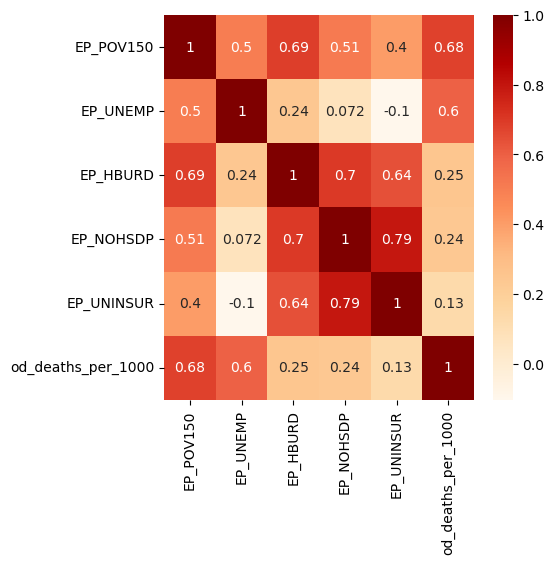

In [30]:
# create a correlation matrix
corr_matrix = metro_svi_deaths_socioeconomic.corr()

# plot the correlation matrix
plt.figure(figsize=(5, 5))
sns.heatmap(corr_matrix, annot=True, cmap='OrRd')   
plt.show()

In [54]:
# split the metro_svi_deaths_socioeconomic data into train and test sets
from sklearn.model_selection import train_test_split

In [55]:
# create X and y
X = metro_svi_deaths_socioeconomic.drop('od_deaths_per_1000', axis=1)
y = metro_svi_deaths_socioeconomic['od_deaths_per_1000']

In [33]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

In [ ]:
selectedVariables = ['EP_POV150','EP_UNEMP','EP_HBURD','EP_NOHSDP','EP_UNINSUR','EP_AGE65','EP_AGE17','EP_DISABL','EP_SNGPNT','EP_LIMENG','EP_MINRTY','EP_MUNIT','EP_MOBILE','EP_CROWD','EP_NOVEH','EP_GROUPQ','od_deaths_per_1000']

In [ ]:
selectedVariablesWithoutY = ['EP_POV150','EP_UNEMP','EP_HBURD','EP_NOHSDP','EP_UNINSUR','EP_AGE65','EP_AGE17','EP_DISABL','EP_SNGPNT','EP_LIMENG','EP_MINRTY','EP_MUNIT','EP_MOBILE','EP_CROWD','EP_NOVEH','EP_GROUPQ']

#### Checking whether relationships in this datset are linear or not

Calculate the correlation coefficient (e.g., Pearson correlation) between each feature and the target variable. A high absolute value of the correlation coefficient suggests a stronger linear relationship.

In [162]:
correlation_matrix = metroSviMultipleVariablesDf.corr()
correlation_with_target = correlation_matrix['od_deaths_per_1000']

In [163]:
correlation_with_target

EP_POV150             0.678769
EP_UNEMP              0.597060
EP_HBURD              0.252899
EP_NOHSDP             0.237926
EP_UNINSUR            0.132393
EP_AGE65              0.261424
EP_AGE17             -0.281845
EP_DISABL             0.707205
EP_SNGPNT            -0.007236
EP_LIMENG            -0.335792
EP_MINRTY            -0.186644
EP_MUNIT             -0.267364
EP_MOBILE             0.383788
EP_CROWD              0.004760
EP_NOVEH              0.232199
EP_GROUPQ             0.444483
od_deaths_per_1000    1.000000
Name: od_deaths_per_1000, dtype: float64

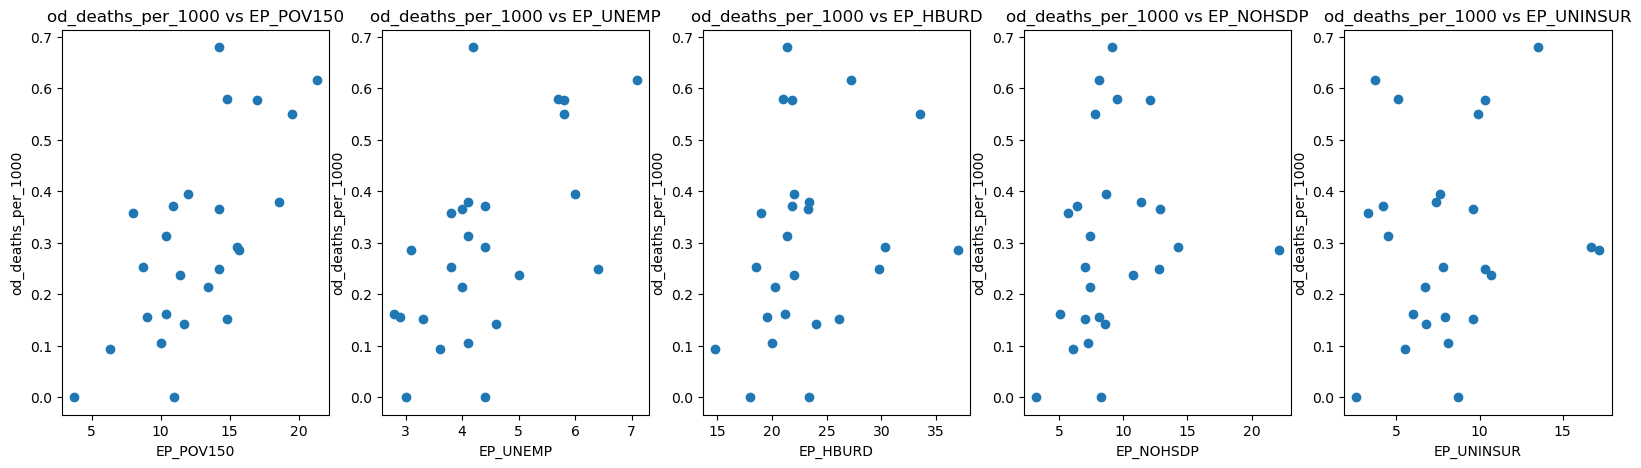

In [164]:
# plot scatter plot for all the variables
fig, axes = plt.subplots(1, 5, figsize=(20, 5))

for idx, var in enumerate(socioeconomic_variable_names):
    axes[idx].scatter(metro_svi_deaths_socioeconomic[var], metro_svi_deaths_socioeconomic['od_deaths_per_1000'])
    axes[idx].set_xlabel(var)
    axes[idx].set_ylabel('od_deaths_per_1000')
    axes[idx].set_title('od_deaths_per_1000 vs ' + var)

plt.show()

### Feature Selection Methods

### I. Filter feature selection methods

In [139]:
metroSviMultipleVariablesDf

,EP_POV150,EP_UNEMP,EP_HBURD,EP_NOHSDP,EP_UNINSUR,EP_AGE65,EP_AGE17,EP_DISABL,EP_SNGPNT,EP_LIMENG,EP_MINRTY,EP_MUNIT,EP_MOBILE,EP_CROWD,EP_NOVEH,EP_GROUPQ,od_deaths_per_1000
0,21.3,7.1,27.2,8.1,3.7,12.2,18.0,11.4,6.9,2.4,63.3,46.8,0.1,3.6,35.4,5.6,0.615407
1,8.0,3.8,19.0,5.7,3.3,14.9,23.2,9.9,4.6,0.3,22.4,3.7,0.9,0.5,2.8,0.6,0.358330
2,10.9,4.4,21.8,6.4,4.2,12.5,24.0,9.9,8.2,1.0,61.7,5.8,0.9,1.8,3.2,1.3,0.371637
3,10.4,4.1,21.4,7.4,4.5,14.5,23.2,10.3,5.9,1.8,27.6,10.3,0.9,1.4,4.0,1.9,0.312555
4,11.7,4.6,24.0,8.6,6.8,15.5,23.2,8.5,5.9,6.4,56.9,27.5,0.1,3.1,7.5,0.8,0.142222
5,14.2,6.4,29.8,12.8,10.3,13.3,22.3,9.7,8.2,6.9,87.7,22.5,0.4,4.3,9.2,2.0,0.249300
6,10.4,2.8,21.2,5.1,6.0,10.8,18.0,6.0,3.3,3.8,39.2,54.1,0.1,3.5,13.9,1.5,0.160721
7,11.0,3.0,23.4,8.3,8.7,21.0,19.5,12.7,3.3,1.1,14.7,3.0,0.3,0.7,3.5,1.4,0.000000
8,14.2,4.0,23.3,12.9,9.6,15.8,24.4,13.3,5.0,3.1,31.0,5.8,3.1,2.8,3.2,2.8,0.365842
9,10.0,4.1,20.0,7.3,8.1,13.5,23.5,7.2,5.1,6.2,50.0,22.8,0.5,3.0,4.4,0.8,0.105269


#### Measure the pearson correlation between the variables

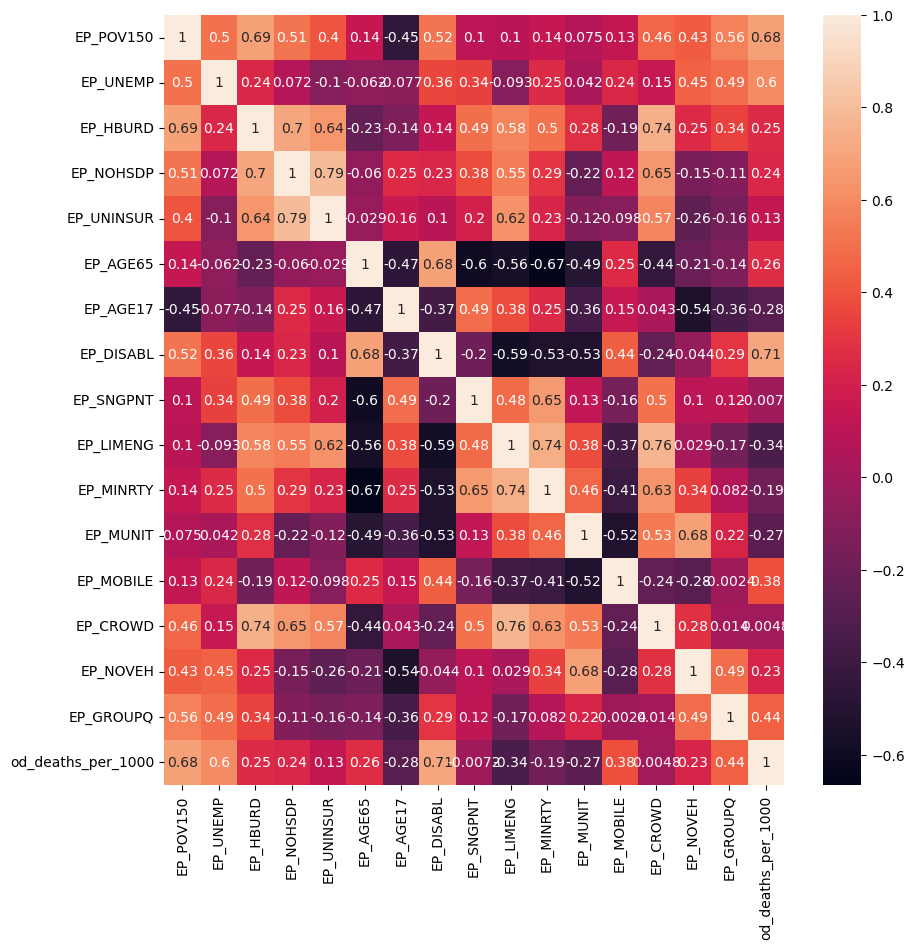

In [140]:
# measure the pearson correlation between the variables
from scipy.stats import pearsonr

# calculate Pearson's correlation matrix   
corr_matrix = metroSviMultipleVariablesDf.corr()

# plot the correlation matrix
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=True)
plt.show()

#### When nonlinear relations are expected we employ Spearman’s Rho	

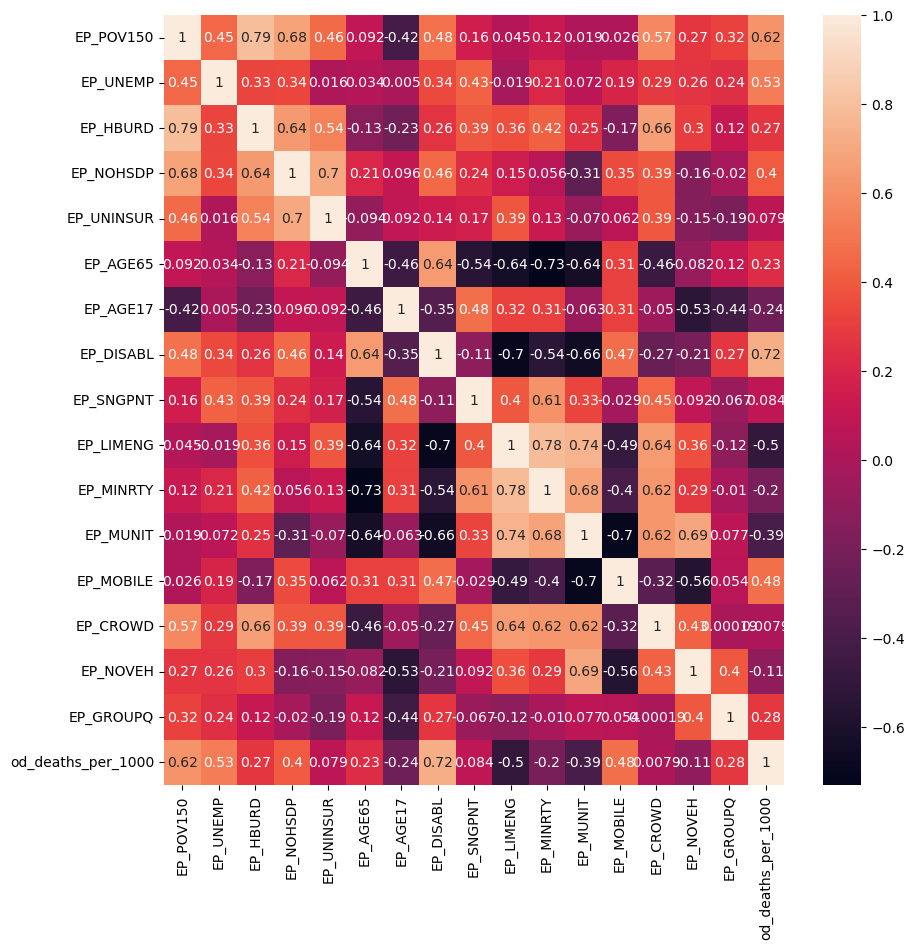

In [141]:
# calculate Spearman’s Rho	
from scipy.stats import spearmanr

# calculate spearman's correlation
coef, p = spearmanr(metroSviMultipleVariablesDf)
# print('Spearmans correlation coefficient: %.3f' % coef)

#plot the heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(coef, annot=True, xticklabels=metroSviMultipleVariablesDf.columns, yticklabels=metroSviMultipleVariablesDf.columns)
plt.show()

Statistical tests can be used to select those features that have the strongest relationship with the output variable. Here we are going to use chi-squared (chi²) statistical test for non-negative features to select 10 of the best features.

#### f_regression statistical test

###### Type of Metric: F-statistic
###### Nature of Relationship: Linear
###### Use Case: Best suited for identifying linear relationships between individual features and the target variable. It is based on the assumption that the relationship between features and the target variable is linear.
###### Output: Provides a score for each feature based on the F-statistic, which indicates how well the feature contributes to the linear regression model.

In [157]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

In [142]:
# create X and y
X = metroSviMultipleVariablesDf.drop('od_deaths_per_1000', axis=1)
y = metroSviMultipleVariablesDf['od_deaths_per_1000']

In [151]:
y.ravel()

array([0.61540741, 0.35832953, 0.37163669, 0.31255494, 0.14222158,
       0.2492996 , 0.16072139, 0.        , 0.36584192, 0.10526874,
       0.15635438, 0.09375493, 0.37855845, 0.23777188, 0.67934783,
       0.39351663, 0.25302127, 0.57661452, 0.15160225, 0.21448181,
       0.        , 0.55060394, 0.29241191, 0.28493276, 0.5797407 ])

In [153]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_regression, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

In [154]:
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns

In [155]:
print(featureScores.nlargest(10,'Score'))  #print 10 best features

        Specs      Score
7   EP_DISABL  23.012836
0   EP_POV150  19.649998
1    EP_UNEMP  12.740949
15  EP_GROUPQ   5.662770
12  EP_MOBILE   3.972925
9   EP_LIMENG   2.922987
6    EP_AGE17   1.984706
11   EP_MUNIT   1.770692
5    EP_AGE65   1.687182
2    EP_HBURD   1.571545


#### mutual_info_regression statistical test

###### Type of Metric: Mutual Information
###### Nature of Relationship: Non-linear and Non-parametric
###### Use Case: Captures any type of statistical dependency, including non-linear relationships. It does not assume a specific form of relationship and can identify complex associations between features and the target variable.
###### Output: Provides a score for each feature based on mutual information, which measures the amount of information one variable (feature) contains about another (target variable).

In [158]:
# Using mutual_info_regression
bestfeatures_mi = SelectKBest(score_func=mutual_info_regression, k=10)
fit_mi = bestfeatures_mi.fit(X, y.ravel())
dfscores_mi = pd.DataFrame(fit_mi.scores_)
dfcolumns_mi = pd.DataFrame(X.columns)
featureScores_mi = pd.concat([dfcolumns_mi, dfscores_mi], axis=1)
featureScores_mi.columns = ['Features', 'Score (mutual_info_regression)']

In [159]:
print(featureScores_mi.nlargest(10, 'Score (mutual_info_regression)'))

     Features  Score (mutual_info_regression)
7   EP_DISABL                        0.371827
6    EP_AGE17                        0.210369
11   EP_MUNIT                        0.197645
1    EP_UNEMP                        0.193499
12  EP_MOBILE                        0.182030
0   EP_POV150                        0.175805
9   EP_LIMENG                        0.172945
8   EP_SNGPNT                        0.160689
15  EP_GROUPQ                        0.135060
10  EP_MINRTY                        0.133480


### II. Wrapper feature selection methods

#### 1. Forward Feature Selection


In [62]:
# filter metro_svi_deaths dataframe to include only the selected variables and od_deaths_per_1000
metroSviMultipleVariablesDf = metro_svi_deaths[selectedVariables]

In [63]:
# create X and y
X = metroSviMultipleVariablesDf.drop('od_deaths_per_1000', axis=1)
y = metroSviMultipleVariablesDf['od_deaths_per_1000']

In [76]:
#forward feature selection
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression

In [73]:
# calling the linear regression model

lreg = LinearRegression()
sfs1 = SFS(lreg, k_features=4, forward=True, verbose=2, scoring='neg_mean_squared_error')

In [74]:
sfs1 = sfs1.fit(X, y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.1s finished

[2023-11-08 10:33:14] Features: 1/4 -- score: -0.020635672106346523[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.1s finished

[2023-11-08 10:33:15] Features: 2/4 -- score: -0.017257112739309903[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished

[2023-11-08 10:33:15] Features: 3/4 -- score: -0.015423742394538031[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: 

In [75]:
feat_names = list(sfs1.k_feature_names_)
print(feat_names)

['EP_POV150', 'EP_UNEMP', 'EP_DISABL', 'EP_CROWD']


In [78]:
# Which features?
feat_cols = list(sfs1.k_feature_idx_)
print(feat_cols)


[0, 1, 7, 13]


#### 2. Backward Feature Selection


In [79]:
# calling the linear regression model

lreg = LinearRegression()
sfs2 = SFS(lreg, k_features=4, forward=False, verbose=2, scoring='neg_mean_squared_error')

In [80]:
sfs2 = sfs2.fit(X, y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.0s finished

[2023-11-09 19:54:58] Features: 15/4 -- score: -0.1647253744817704[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.0s finished

[2023-11-09 19:54:58] Features: 14/4 -- score: -0.11284444488459222[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished

[2023-11-09 19:54:58] Features: 13/4 -- score: -0.08259296181406421[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: D

In [81]:
feat_names = list(sfs2.k_feature_names_)
print(feat_names)

['EP_POV150', 'EP_NOHSDP', 'EP_MINRTY', 'EP_MUNIT']


### III. Embedded feature selection method

#### Lasso regression

In [85]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold

In [87]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [88]:
print("Shape of Train Features: {}".format(X_train.shape))
print("Shape of Test Features: {}".format(X_test.shape))
print("Shape of Train Target: {}".format(y_train.shape))
print("Shape of Test Target: {}".format(y_test.shape))

Shape of Train Features: (20, 16)
Shape of Test Features: (5, 16)
Shape of Train Target: (20,)
Shape of Test Target: (5,)


In [89]:
# parameters to be tested on GridSearchCV
params = {"alpha":np.arange(0.00001, 10, 500)}

In [90]:
# Number of Folds and adding the random state for replication
kf=KFold(n_splits=5,shuffle=True, random_state=42)

In [91]:
# Initializing the Model
lasso = Lasso()

In [92]:
# GridSearchCV with model, params and folds.
lasso_cv=GridSearchCV(lasso, param_grid=params, cv=kf)
lasso_cv.fit(X, y)
print("Best Params {}".format(lasso_cv.best_params_))

Best Params {'alpha': 1e-05}


/Users/h6x/anaconda3/envs/TDA/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.418e-02, tolerance: 8.008e-05
  model = cd_fast.enet_coordinate_descent(
/Users/h6x/anaconda3/envs/TDA/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.613e-02, tolerance: 8.072e-05
  model = cd_fast.enet_coordinate_descent(
/Users/h6x/anaconda3/envs/TDA/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing 

In [97]:
names=metroSviMultipleVariablesDf.drop("od_deaths_per_1000", axis=1).columns
print("Column Names: {}".format(names.values))

Column Names: ['EP_POV150' 'EP_UNEMP' 'EP_HBURD' 'EP_NOHSDP' 'EP_UNINSUR' 'EP_AGE65'
 'EP_AGE17' 'EP_DISABL' 'EP_SNGPNT' 'EP_LIMENG' 'EP_MINRTY' 'EP_MUNIT'
 'EP_MOBILE' 'EP_CROWD' 'EP_NOVEH' 'EP_GROUPQ']


In [93]:
#Using Lasso Regressor to plot the best features.

# calling the model with the best parameter
lasso1 = Lasso(alpha=0.00001)
lasso1.fit(X_train, y_train)

# Using np.abs() to make coefficients positive.  
lasso1_coef = np.abs(lasso1.coef_)

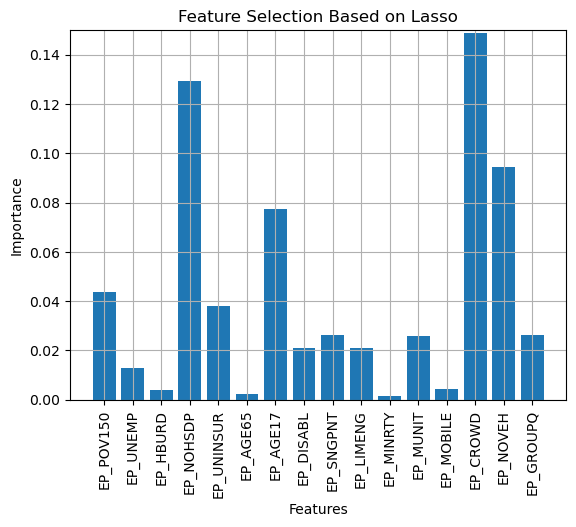

In [98]:
# plotting the Column Names and Importance of Columns. 
plt.bar(names, lasso1_coef)
plt.xticks(rotation=90)
plt.grid()
plt.title("Feature Selection Based on Lasso")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.ylim(0, 0.15)
plt.show()

In [99]:
# Subsetting the features which has more than 0.001 importance.
feature_subset=np.array(names)[lasso1_coef>0.001]
print("Selected Feature Columns: {}".format(feature_subset))

Selected Feature Columns: ['EP_POV150' 'EP_UNEMP' 'EP_HBURD' 'EP_NOHSDP' 'EP_UNINSUR' 'EP_AGE65'
 'EP_AGE17' 'EP_DISABL' 'EP_SNGPNT' 'EP_LIMENG' 'EP_MINRTY' 'EP_MUNIT'
 'EP_MOBILE' 'EP_CROWD' 'EP_NOVEH' 'EP_GROUPQ']


In [100]:
#################

In [101]:
from sklearn.preprocessing import StandardScaler

In [118]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

,EP_POV150,EP_UNEMP,EP_HBURD,EP_NOHSDP,EP_UNINSUR,EP_AGE65,EP_AGE17,EP_DISABL,EP_SNGPNT,EP_LIMENG,EP_MINRTY,EP_MUNIT,EP_MOBILE,EP_CROWD,EP_NOVEH,EP_GROUPQ
9,10.0,4.1,20.0,7.3,8.1,13.5,23.5,7.2,5.1,6.2,50.0,22.8,0.5,3.0,4.4,0.8
13,11.4,5.0,22.0,10.8,10.7,9.9,27.1,7.9,6.4,5.8,58.3,13.5,1.1,3.2,2.3,0.8
1,8.0,3.8,19.0,5.7,3.3,14.9,23.2,9.9,4.6,0.3,22.4,3.7,0.9,0.5,2.8,0.6
22,15.5,4.4,30.3,14.3,16.7,10.4,26.7,6.8,8.3,11.9,60.4,17.3,1.3,4.7,4.2,0.2
5,14.2,6.4,29.8,12.8,10.3,13.3,22.3,9.7,8.2,6.9,87.7,22.5,0.4,4.3,9.2,2.0
2,10.9,4.4,21.8,6.4,4.2,12.5,24.0,9.9,8.2,1.0,61.7,5.8,0.9,1.8,3.2,1.3
12,18.6,4.1,23.4,11.4,7.4,23.2,20.8,13.5,4.6,0.2,15.3,0.4,3.6,3.2,1.6,1.5
15,12.0,6.0,22.0,8.7,7.6,14.1,24.8,11.3,5.3,1.6,32.7,6.6,4.2,2.0,3.0,0.3
3,10.4,4.1,21.4,7.4,4.5,14.5,23.2,10.3,5.9,1.8,27.6,10.3,0.9,1.4,4.0,1.9
4,11.7,4.6,24.0,8.6,6.8,15.5,23.2,8.5,5.9,6.4,56.9,27.5,0.1,3.1,7.5,0.8


In [113]:
scaler = StandardScaler().fit(X_train[selectedVariablesWithoutY]) 
X_train = scaler.transform(X_train[selectedVariablesWithoutY])

X_test = scaler.transform(X_test[selectedVariablesWithoutY])

In [123]:
X_train

,EP_POV150,EP_UNEMP,EP_HBURD,EP_NOHSDP,EP_UNINSUR,EP_AGE65,EP_AGE17,EP_DISABL,EP_SNGPNT,EP_LIMENG,EP_MINRTY,EP_MUNIT,EP_MOBILE,EP_CROWD,EP_NOVEH,EP_GROUPQ
9,10.0,4.1,20.0,7.3,8.1,13.5,23.5,7.2,5.1,6.2,50.0,22.8,0.5,3.0,4.4,0.8
13,11.4,5.0,22.0,10.8,10.7,9.9,27.1,7.9,6.4,5.8,58.3,13.5,1.1,3.2,2.3,0.8
1,8.0,3.8,19.0,5.7,3.3,14.9,23.2,9.9,4.6,0.3,22.4,3.7,0.9,0.5,2.8,0.6
22,15.5,4.4,30.3,14.3,16.7,10.4,26.7,6.8,8.3,11.9,60.4,17.3,1.3,4.7,4.2,0.2
5,14.2,6.4,29.8,12.8,10.3,13.3,22.3,9.7,8.2,6.9,87.7,22.5,0.4,4.3,9.2,2.0
2,10.9,4.4,21.8,6.4,4.2,12.5,24.0,9.9,8.2,1.0,61.7,5.8,0.9,1.8,3.2,1.3
12,18.6,4.1,23.4,11.4,7.4,23.2,20.8,13.5,4.6,0.2,15.3,0.4,3.6,3.2,1.6,1.5
15,12.0,6.0,22.0,8.7,7.6,14.1,24.8,11.3,5.3,1.6,32.7,6.6,4.2,2.0,3.0,0.3
3,10.4,4.1,21.4,7.4,4.5,14.5,23.2,10.3,5.9,1.8,27.6,10.3,0.9,1.4,4.0,1.9
4,11.7,4.6,24.0,8.6,6.8,15.5,23.2,8.5,5.9,6.4,56.9,27.5,0.1,3.1,7.5,0.8


In [119]:
reg = Lasso(alpha=1)
reg.fit(X_train, y_train)

Lasso(alpha=1)

In [120]:
print('R squared training set', round(reg.score(X_train, y_train)*100, 2))
print('R squared test set', round(reg.score(X_test, y_test)*100, 2))

R squared training set 13.3
R squared test set -31.09


In [124]:
from sklearn.metrics import mean_squared_error

# Training data
pred_train = reg.predict(X_train)
mse_train = mean_squared_error(y_train, pred_train)
print('MSE training set', round(mse_train, 2))

# Test data
pred = reg.predict(X_test)
mse_test =mean_squared_error(y_test, pred)
print('MSE test set', round(mse_test, 2))

MSE training set 0.03
MSE test set 0.04


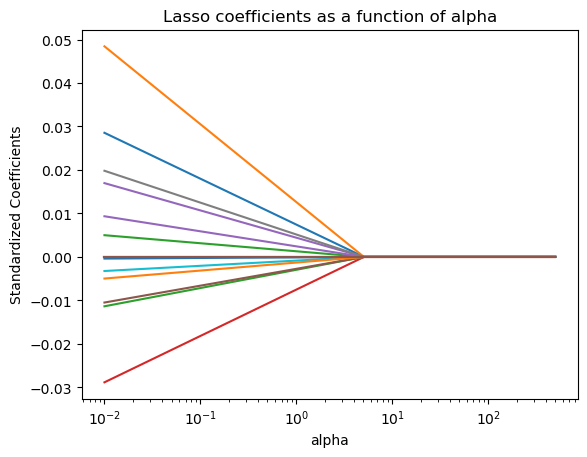

In [125]:
import numpy as np
import matplotlib.pyplot as plt

alphas = np.linspace(0.01,500,100)
lasso = Lasso(max_iter=10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Standardized Coefficients')
plt.title('Lasso coefficients as a function of alpha');